# Build Project: Exploring Sentiment Around Tourism and Overtourism Through Twitter Data
### Created By: Alana Ahart, Build Student Consultant
### Completed: August 2025


## Project Overview:
  Over 9,000 tweets were collected using Twitter’s API to examine public sentiment and emotional tone surrounding tourism and overtourism. Sentiment and emotion analysis were applied to uncover patterns in recent posts. Due to developer subscription constraints, tweets were retrieved within a one week window and capped at 10,000 tweets per month. Despite these limitations, the project aimed to capture a snapshot of current public attitudes and identify emerging trends in the conversation around tourism.

In [ ]:
!pip install tweepy
!pip install transformers
!pip install spacy
!pip install textblob
import tweepy
import csv
from transformers import pipeline
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

  Using cached numpy-2.3.2-cp311-cp311-macosx_10_9_x86_64.whl.metadata (62 kB)
Using cached numpy-2.3.2-cp311-cp311-macosx_10_9_x86_64.whl (21.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
captum 0.8.0 requires numpy<2.0, but you have numpy 2.3.2 which is incompatible.
astropy 5.3.4 requires numpy<2,>=1.21, but you have numpy 2.3.2 which is incompatible.
numba 0.59.0 requires numpy<1.27,>=1.22, but you have numpy 2.3.2 which is incompatible.
neuralprophet 0.9.0 requires numpy<2.0.0,>=1.25.0, but you have numpy 2.3.2 which is incompatible.
pywavelets 1.5.0 requires numpy<2.0,>=1.22.4, but you have numpy 2.3.2 which is incompatible.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alanaahart/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alanaahart/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alanaahart/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Tweet Collection Using Twitter API

### Tweets were collected from the twitter API:
    1. Input your bearer_token and create a query of key words.
    2. Collect Tweets using pagination.
    3. Save to csv file.

In [ ]:
#token from twitter API
bearer_token = "Input Your Bearer Token"

client = tweepy.Client(bearer_token=bearer_token)

query = '(tourism OR travel OR vacation OR "tourist destination" OR overtourism OR "responsible travel" OR "sustainable tourism" OR "too many tourists" OR "tourist boom" OR "family vacation" OR "honeymoon vacation" OR "summer holiday" OR "family trip" OR #travel OR #vacation OR #overtourism OR #antitourism OR #overtourism OR #touristsgohome OR #touristtrap OR #ecotourism OR #instatravel) lang:en -is:retweet'

In [ ]:
#pagination to get more then 100 tweets
next_token = None
target_count = 9053
all_tweets = []
collected_count = 0

while collected_count < target_count:
    try:

        if next_token:
            response = client.search_recent_tweets(
                query=query,
                max_results=100,
                next_token=next_token
            )
        else:
            response = client.search_recent_tweets(
                query=query,
                max_results=100
            )

        if not response.data:
            print("No more tweets available")
            break


        for tweet in response.data:
            try:
                tweet_data = {
                    'id': tweet.id,
                    'text': tweet.text,
                    'created_at': tweet.created_at,

                }
                all_tweets.append(tweet_data)
                collected_count += 1

                if collected_count >= target_count:
                    break
            except AttributeError:

                continue


        if hasattr(response, 'meta') and 'next_token' in response.meta:
            next_token = response.meta['next_token']
        else:
            print("No more pages available")
            break

        print(f"Collected {collected_count} tweets so far")


        time.sleep(2)

    except Exception as e:
        print(f"Error: {e}")
        time.sleep(60)

# Save tweets to csv
pd.DataFrame(all_tweets).to_csv('tweets.csv', index=False)
print(f"Finished collecting {collected_count} tweets")

Collected 100 tweets so far
Collected 200 tweets so far
Collected 300 tweets so far
Collected 400 tweets so far
Collected 500 tweets so far
Collected 600 tweets so far
Collected 700 tweets so far
Collected 800 tweets so far
Collected 900 tweets so far
Collected 1000 tweets so far
Collected 1100 tweets so far
Collected 1199 tweets so far
Collected 1299 tweets so far
Collected 1398 tweets so far
Collected 1498 tweets so far
Collected 1598 tweets so far
Collected 1698 tweets so far
Collected 1798 tweets so far
Collected 1898 tweets so far
Collected 1998 tweets so far
Collected 2098 tweets so far
Collected 2198 tweets so far
Collected 2298 tweets so far
Collected 2398 tweets so far
Collected 2497 tweets so far
Collected 2597 tweets so far
Collected 2697 tweets so far
Collected 2796 tweets so far
Collected 2896 tweets so far
Collected 2996 tweets so far
Collected 3096 tweets so far
Collected 3195 tweets so far
Collected 3295 tweets so far
Collected 3395 tweets so far
Collected 3494 tweets s

## Pre-processing Tweets

### After the tweets have been pulled from the Twitter API, they are pre-processed:
    1. Hashtags are seperated and placed in their own column.
    2. Every tweet is made lowercase.
    3. Emojis, links, special characters,mentions, stop words are removed.
    6. Applied lemmatization so words are reduced to their base dictionary form.
    7. Duplicate tweets are removed.
    8. After tweets processed they are saved in csv file.
    


In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


df = pd.read_csv('tweets.csv')
df_copy = df.copy()
text_column = 'text'

In [ ]:
def tweet_preprocess(text):
    #Seperate hashtags
    hashtags = re.findall(r'#(\w+)', text)
    hashtags_str = ' '.join(hashtags)

    #make everything lowercase
    text = text.lower()
    #remove emojis
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)
    #remove links
    text = re.sub(r'http\S+|www\S+', '', text)
    #remove mentions
    text = re.sub(r'@\w+', '', text)
    #remove special characters
    text = re.sub(r'[^a-z\s]', '', text)

    #remove stop words, lemmization

    tokens = word_tokenize(text)
    cleaned = [
        lemmatizer.lemmatize(word) for word in tokens
        if word not in stop_words and word.isalpha()
    ]

    return ' '.join(cleaned), hashtags_str


df_copy[['cleaned_tweet', 'hashtags']] = df_copy[text_column].astype(str).apply(
    lambda x: pd.Series(tweet_preprocess(x))
)

In [ ]:
#remove duplicates after the tweets are preprocessed
df_copy = df_copy.drop_duplicates(subset='cleaned_tweet')

Pre-processed tweets are saved to csv final_tweets.csv

In [ ]:
 df_copy.to_csv('final_tweets.csv', index=False)

Preview final_tweets.csv:

In [ ]:
pd.read_csv('final_tweets.csv').head()


,id,text,created_at,cleaned_tweet,hashtags
0,1954895590120362217,maybe some people will not travel there now. #...,NaN,maybe people travel visa,visas
1,1954895582855675933,@dpshow I thought Dan might cancel vacation so...,NaN,thought dan might cancel vacation could talk s...,NaN
2,1954895579018055765,🚀 Just joined the quest!\nSign up on @travalac...,NaN,joined quest sign amp win usdt travala crypton...,NaN
3,1954895575775940884,@shiv9236 @MeghUpdates Air India has suspended...,NaN,air india suspended flight washington dc covid...,NaN
4,1954895574395748586,I'm on vacation😎 https://t.co/EhukkvjtJR,NaN,im vacation,NaN


## Sentiment Analysis

### Using the libraries, textblob and WordCloud, I applied sentiment analysis on the collected tweets.  

In [ ]:
from textblob import TextBlob


 ## TextBlob assigns each tweet a sentiment polarity score ranging from −1 to +1.
    A negative score indicates negative sentiment
    A positive score reflects positive sentiment
    A score near zero suggests a neutral tone

## After pre-precossing, there were 8,332 tweets available for analysis.  The mean polarity score of the tweets are 0.10.  The minimum score was -1 and the max score was 1, showing that positive and negative tweets are present in the data.  A mean score of 0.10 indicates that the tweets lean slightly more positive but close to neutral.

In [ ]:
df = pd.read_csv('final_tweets.csv')
df["Sentiment"] = df["cleaned_tweet"].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)
print(df["Sentiment"].describe())


count    8332.000000
mean        0.106851
std         0.261624
min        -1.000000
25%         0.000000
50%         0.018899
75%         0.250000
max         1.000000
Name: Sentiment, dtype: float64


In [ ]:
#had issues with installing the packages
!pip uninstall -y pillow wordcloud

!pip install pillow==9.5.0
!pip install wordcloud==1.9.2


from wordcloud import WordCloud


print("WordCloud successfully imported!")

Found existing installation: pillow 11.3.0
Uninstalling pillow-11.3.0:
  Successfully uninstalled pillow-11.3.0
Found existing installation: wordcloud 1.9.4
Uninstalling wordcloud-1.9.4:
  Successfully uninstalled wordcloud-1.9.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 4.3 MB/s  0:00:00 eta 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
neuralprophet 0.9.0 requires numpy<2.0.0,>=1.25.0, but you have numpy 2.3.2 which is incompatible.
WordCloud successfully imported!


In [ ]:
import matplotlib.pyplot as plt

View available columns in dataframe:

In [ ]:
#column names
print("Available columns:", df.columns.tolist())

Available columns: ['id', 'text', 'created_at', 'cleaned_tweet', 'hashtags', 'Sentiment']


Create word cloud of tweets:

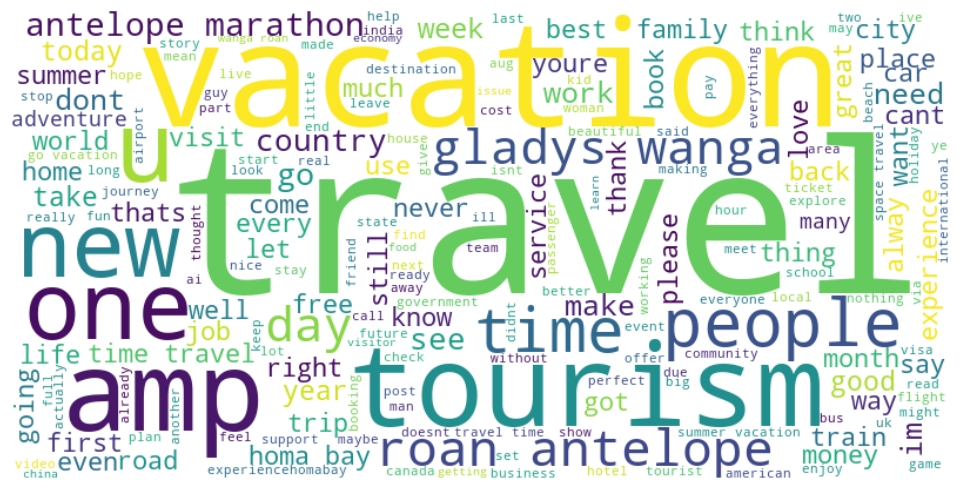

In [ ]:
tweet = " ".join(df['cleaned_tweet'].astype(str).tolist())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400,
                     background_color='white',
                     max_words=200).generate(tweet)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

## What are the top words identified in the tweets?
  When reviewing the word cloud, the words that appeared largest, meaning they occurred most often in the dataset,included: vacation, travel, time, people, new, tourism, one, amp, and new. One phrase that stood out to me was “antelope marathon,” which showed up a few times in the word cloud as “antelope marathon” and “roan antelope.” I believe this refers to the Roan Antelope Marathon in Kenya, where they raise money for antelope conservation. This race must have been happening or was being promoted during the time I was collecting tweets.

Create word cloud of tweets that have been identified as having negative sentiment (<0):

Number of negative tweets: 1576


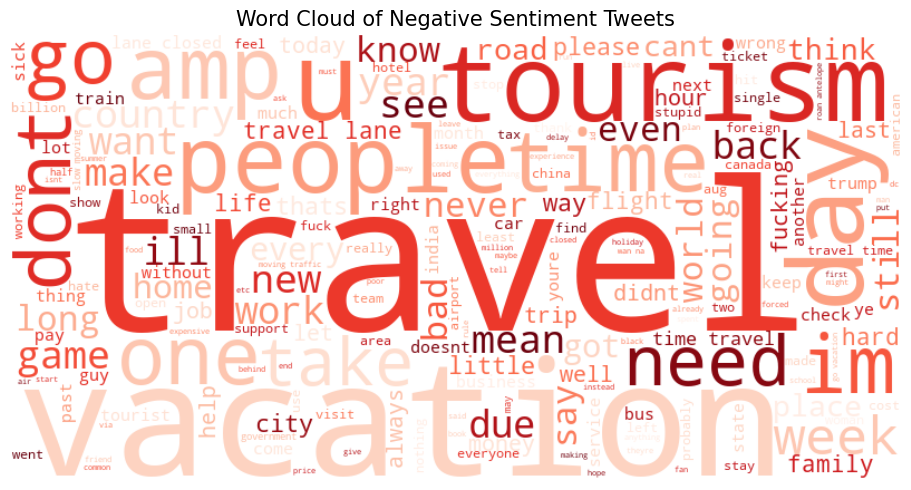

In [ ]:
#word cloud on negative sentiment
negative_tweets = df[df["Sentiment"] < 0]

#negative tweets to string
negative_text = " ".join(negative_tweets["cleaned_tweet"].astype(str).tolist())

wordcloud = WordCloud(width=800, height=400,
                     background_color='white',
                     max_words=200,
                     colormap='Reds').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.title("Word Cloud of Negative Sentiment Tweets", fontsize=15)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()


## What are the top words identified in the tweets that have negative sentiment?
  Some of the words that showed up frequently in tweets with negative sentiment include: travel, tourism, people, time, day, don’t, go, mean, need, and week. Words that stood out to me were: sick, working, bad, mean, and never.

  When comparing the word clouds for the overall dataset and the subset of negative tweets, the words people and time appeared noticeably larger in the negative sentiment word cloud. In contrast, don’t was relatively small in the overall word cloud but showed a much stronger presence in the negative sentiment analysis.
    

Create a word cloud of hashtags present in the dataframe:

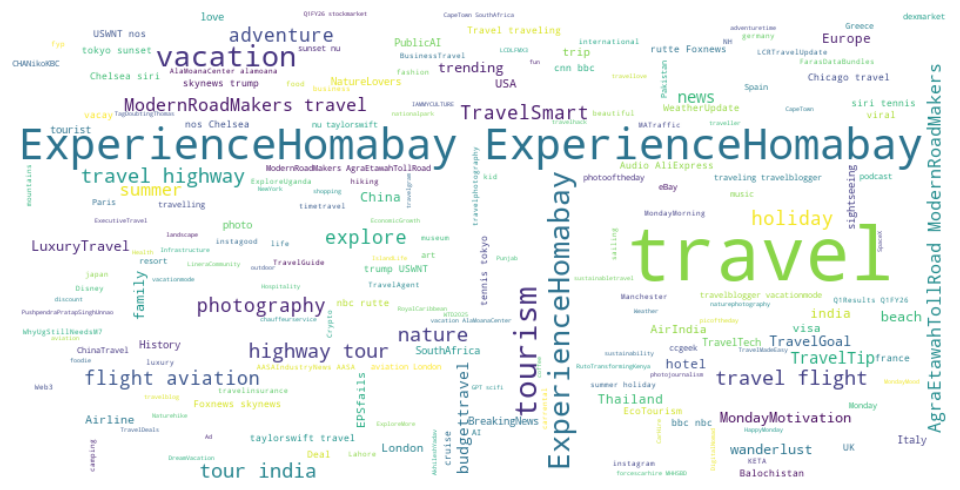

In [ ]:
hashtag_tweets = " ".join(df['hashtags'].dropna().astype(str).tolist())
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400,
                     background_color='white',
                     max_words=200).generate(hashtag_tweets)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

## What are the top words in the hashtags?
  ExperienceHomabay, ModernRoadMakers, travel, tourism, and vacation had a strong presence in the word cloud. Many of the hashtags appear to reference businesses,for example, Modern Road Makers is a company that builds highways. The hashtag #ExperienceHomabay is associated with the location where the Antelope Marathon took place, which explains its prominent appearance in the dataset.

Generate a bar chart comparing the number of tweets for each sentiment category:

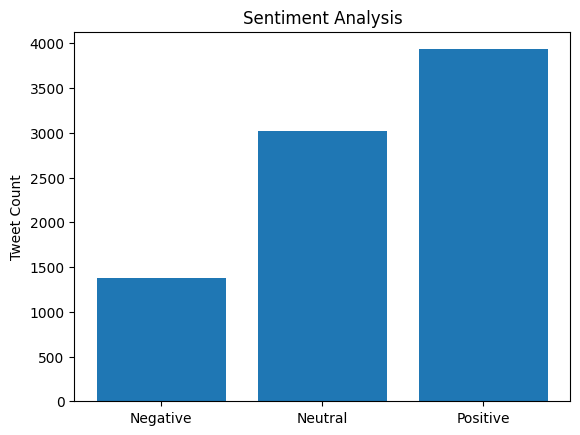

In [ ]:

sentiment_col = df["Sentiment"]

NEUTRAL_BAND = 0.05
cats = pd.cut(
    sentiment_col,
    bins=[-1.0, -NEUTRAL_BAND, NEUTRAL_BAND, 1.0],
    labels=["Negative", "Neutral", "Positive"],
    include_lowest=True
).astype("category")

counts = cats.value_counts().reindex(["Negative","Neutral","Positive"])
fig, ax = plt.subplots()
ax.bar(counts.index, counts.values)
ax.set(title="Sentiment Analysis", ylabel="Tweet Count")
plt.show()


## What is the overall distribution of sentiment in the tweets?
  Among the 8,332 tweets analyzed, negative sentiment accounted for less than 18% of the total. Positive tweets slightly outnumbered neutral ones, indicating an overall optimistic tone in the dataset.

### How many tweets had positive sentiment?

In [ ]:
pos_tweets = df[df["Sentiment"] > 0]

# Check how many positive tweets we have
print(f"Number of positive tweets: {len(pos_tweets)}")

Number of positive tweets: 4253


### How many tweets had neutral sentiment?

In [ ]:
neut_tweets = df[df["Sentiment"] == 0]

# Check how many neutral tweets we have
print(f"Number of neutral tweets: {len(neut_tweets)}")

Number of neutral tweets: 2503


### How many tweets had negative sentiment?

In [ ]:
# Check how many negative tweets we have
print(f"Number of negative tweets: {len(negative_tweets)}")

Number of negative tweets: 1576


## Emotion Analysis

In [ ]:
!pip install pandas transformers torch

Set up emotion classifier pipeline to score emotions of tweets:

In [ ]:
emotion_classifier = pipeline("text-classification",model="bhadresh-savani/distilbert-base-uncased-emotion",return_all_scores=True)


config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu
/opt/anaconda3/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Get emotion scores from each tweet, split them into separate columns by emotion, and save to a csv:

In [ ]:
def get_emotions(text):
    try:
        scores=emotion_classifier(text[:512])
        return {item['label']: item['score'] for item in scores[0]}
    except:
        return {}

df['emotions'] = df['cleaned_tweet'].apply(get_emotions)

emotion_df = df['emotions'].apply(pd.Series)
df = pd.concat([df, emotion_df], axis=1)

df.to_csv('emotion_tweets.csv',index=False)

In [ ]:
df_emotion = pd.read_csv('emotion_tweets.csv')

Preview columns:

In [ ]:
print("Available columns:", df_emotion.columns.tolist())

Available columns: ['id', 'text', 'created_at', 'cleaned_tweet', 'hashtags', 'Sentiment', 'emotions', 'sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


Plot the average emotion scores for each emotion:

<Axes: title={'center': 'Average Emotion Scores'}>

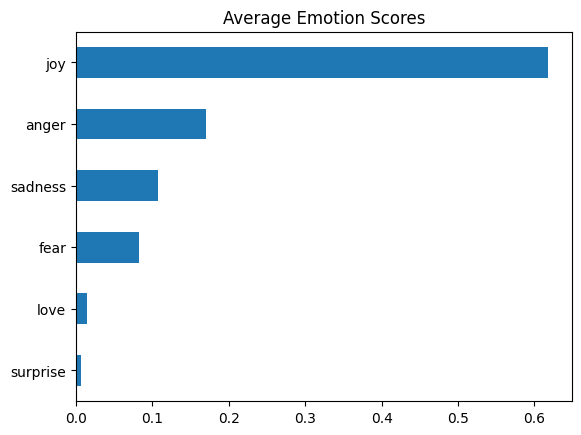

In [ ]:
emotion_cols = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
df_emotion[emotion_cols].mean().sort_values().plot(kind='barh', title='Average Emotion Scores')


## What are the average emotion scores of the tweets?
  Emotion scores range from 0 to 1, with higher values indicating stronger emotional presence in the data. Among tweets, joy consistently received the highest scores, suggesting that posts related to travel and tourism tends to have positive sentiment. In contrast, surprise had the lowest scores, indicating that the emotion was rarely expressed.

# Conclusion

 After conducting sentiment and emotion analysis on over 8,000 tweets related to tourism and vacation the overall sentiment leaned slightly positive. The most prominent emotion across the dataset was joy, suggesting that, during the collection period, public conversation around vacations reflected a positive tone.

One notable event that sparked significant engagement was the marathon in Homa Bay, which stood out as a moment of heightened conversation and emotional resonance.

If I were to revisit this project, I would expand the data collection window to cover a longer time span. This would allow for a broader range of tweets and potentially reveal seasonal or event driven shifts in sentiment and emotion.